1.15,只考虑时间因素下的模型,用零膨胀的方法
---

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA

import scipy as sp
from theano.compile.ops import as_op
from numpy import arange, array, empty
from Plot_raw import *

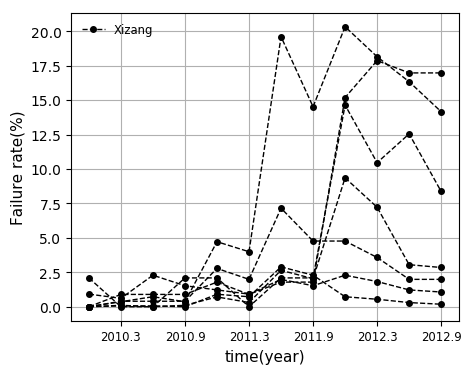

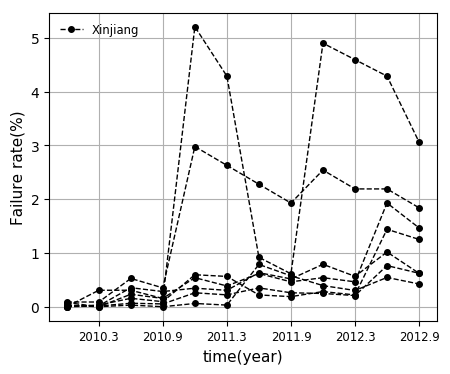

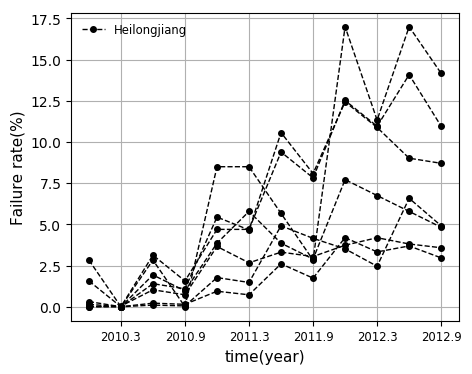

In [18]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储
plt.style.use('default')
elec_data = pd.read_csv('XZmulti_12.csv')
# elec_data = pd.read_csv('XZmulti_12sametem.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values
# print(companyABC)
# print(companiesABC)
# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 1, size=[len(elec_data.Year.values), 3])

# #特征因素分析
elec_tem = elec_data.Tem.values # 观测温度值x2，温度不加噪声
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 0]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 1] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 2] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)


# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year
# print(data_cs_year)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
# elec_Pca2 = np.vstack((elec_tem, elec_hPa, elec_RH, elec_Lux)).T   # 特征数据合并为一个数组
# np.savetxt('XZ_nomean.csv', elec_Pca2, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=2)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)

elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2
print('\n')

# elec_data.Fault.values[48] =2000
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 1000 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
# elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)

# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*12:(i+1)*12] for i in np.arange(21)])
elec_char1 = np.array([elec_Pca_char1[i*12:(i+1)*12] for i in np.arange(21)])
elec_char2 = np.array([elec_Pca_char2[i*12:(i+1)*12] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*12:(i+1)*12] for i in np.arange(21)])

Plot_raw(elec_year2, elec_faults2, Savefig)
# 共享变量设置
# xs_char1 = shared(np.asarray(elec_Pca_char1))
# xs_char2 = shared(np.asarray(elec_Pca_char2))

# ys_faults = shared(np.asarray(elec_faults))
# xs_year = shared(np.asarray(data_cs_year))
# Num_shared = shared(np.asarray(companyABC))

def logit(x):
    return 1/(1+np.exp(-x))
def Invlogit(x):
    return tt.exp(x)/(1+tt.exp(x))

In [19]:
# 采用三次B样条基函数进行拟合
x_zhou = 12
Num = len(elec_faults)
knots = np.linspace(1, x_zhou, Num)

Num_5 = 5 * len(elec_faults)
model_knots = np.linspace(1, x_zhou, Num_5)

# 能否将这里代码改为@as_op的形式，来让x的值得以调用
basis_funcs = sp.interpolate.BSpline(knots, np.eye(Num_5), k=3) # eye()生成对角矩阵
Bx = basis_funcs(elec_year)  # 表示在取值为x时的插值函数值
# BxB = basis_funcs(elec_year[0:168])  # 表示在取值为x时的插值函数值
# BxC = basis_funcs(elec_year[0:84])  # 表示在取值为x时的插值函数值
# shared:符号变量（symbolic variable），a之所以叫shared variable是因为a的赋值在不同的函数中都是一致的搜索，即a是被shared的
Bx_ = shared(Bx)
# Bx_B = shared(BxB)
# Bx_C = shared(BxC)

In [20]:
change,changeB,changeC = np.array([0 for i in np.arange(len(elec_year))]),\
                            np.array([0 for i in np.arange(len(elec_year))]),\
                                np.array([0 for i in np.arange(len(elec_year))])
# change = np.array(company)
change[:84] = 1
changeB[84:168] = 1
changeC[168:] = 1
print(change)
# print(changeB)
# print(changeC)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [26]:
# 建模，模型
# import ipyparallel as ipp
with pm.Model() as model_1:
    # define priors
    sdd = pm.HalfCauchy('sdd', 10.)
    
    σ_a = pm.HalfCauchy('σ_a', 5.)
    a0 = pm.Normal('a0', 0., 20.)
    Δ_a = pm.Normal('Δ_a', 0., 10., shape = (Num_5))
    
#     sd_A = pm.HalfCauchy('sd_A', 5)
#     sd_B = pm.HalfCauchy('sd_B', 5)
#     sd_C = pm.HalfCauchy('sd_C', 5)
    δ = pm.Normal('δ', 0, sd=(1)) # 若模型收敛差则δ改用这个语句
    δB = pm.Normal('δB', 0, sd=(1)) # 若模型收敛差则δ改用这个语句
    δC = pm.Normal('δC', 0, sd=(1)) # 若模型收敛差则δ改用这个语句
    
#     beta0 = pm.Normal('beta0', 0, sd=20)
#     beta = pm.Normal('beta', 0, sd=20)
#     beta1 = pm.Normal('beta1', 0, sd=20)
#      beta*elec_tem1 + beta1*elec_RH1
    theta1 = pm.Deterministic('theta1', a0 + (σ_a * Δ_a).cumsum())
    theta = pm.Deterministic('theta',   tt.exp(change*(Bx_.dot(theta1)+δ) +  \
                                                    changeB*(Bx_.dot(theta1) +δB) +  \
                                                        changeC*(Bx_.dot(theta1) +δC)))
    
    alpha1 = pm.Normal('alpha1', 0, 10)
    alpha = pm.Normal('alpha', 0, 10)
    psi = pm.Deterministic('psi', Invlogit(alpha + alpha1*elec_year))
    
    Observed = pm.ZeroInflatedNegativeBinomial('Observed',psi=psi, mu =theta, alpha =sdd ,observed=elec_faults)  # 观测值
#     start = pm.find_MAP()
    trace_1 = pm.sample(1000, njobs=1)
#     ,  init='advi+adapt_diag'

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [08:41<00:00,  2.88it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 740 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



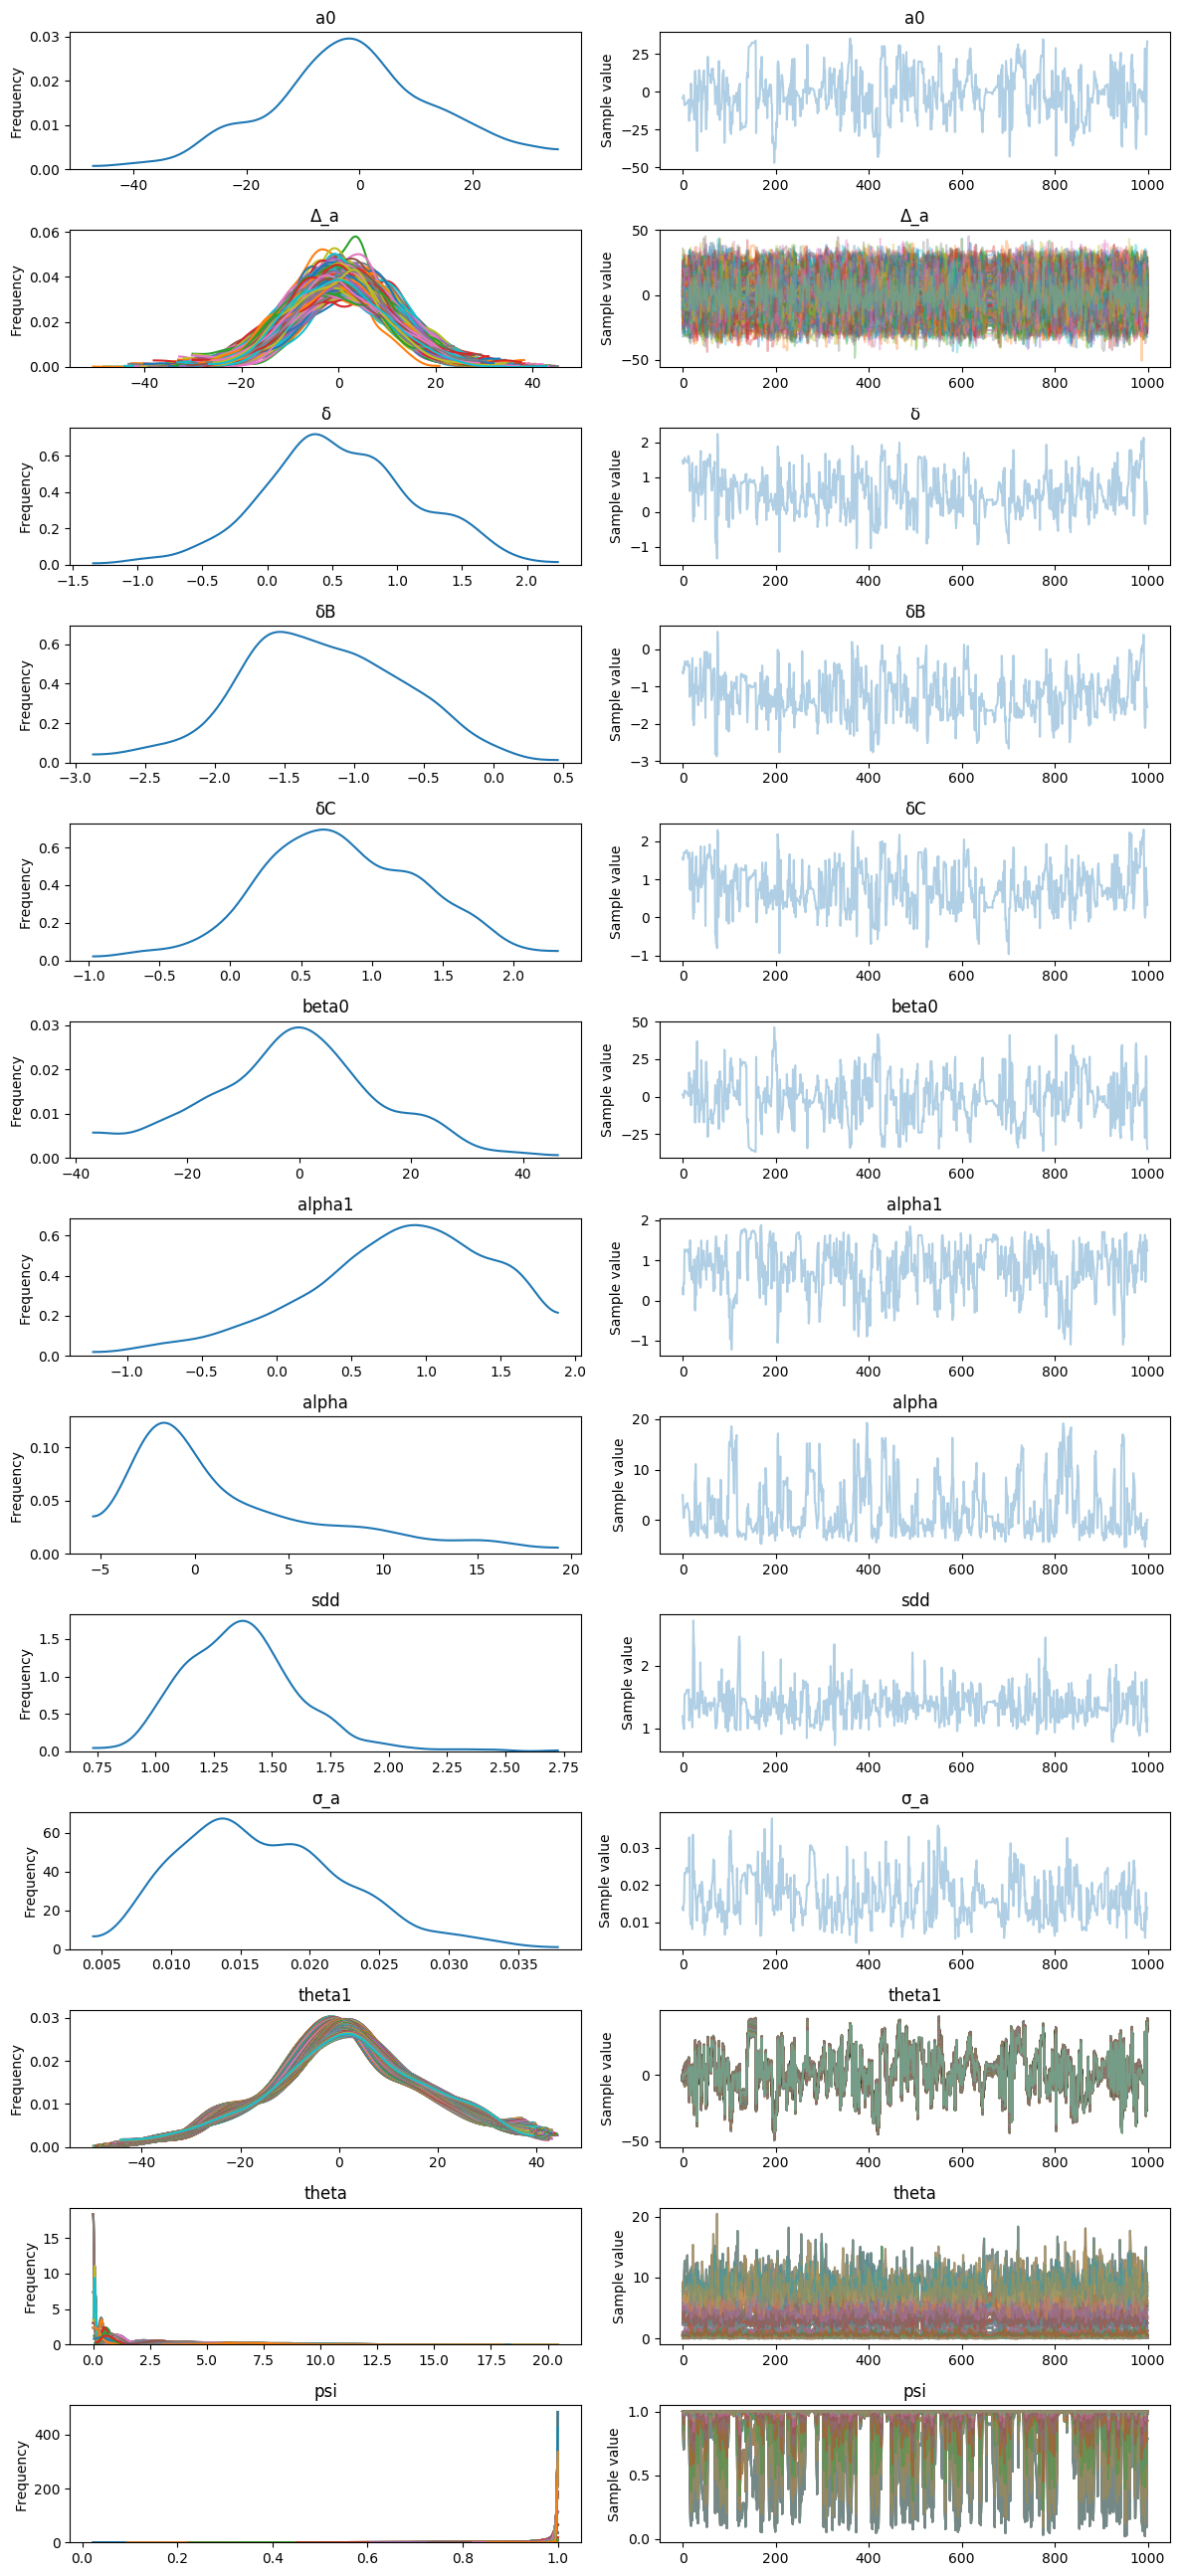

In [27]:
pm.traceplot(trace_1)
plt.show()

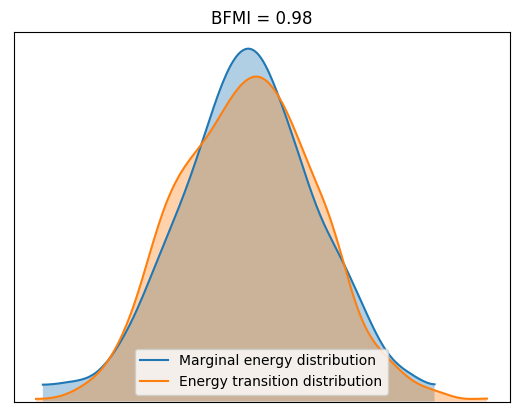

In [28]:
ax = pm.energyplot(trace_1)
bfmi = pm.bfmi(trace_1)
ax.set_title(f"BFMI = {bfmi:.2f}");
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 920.85it/s]


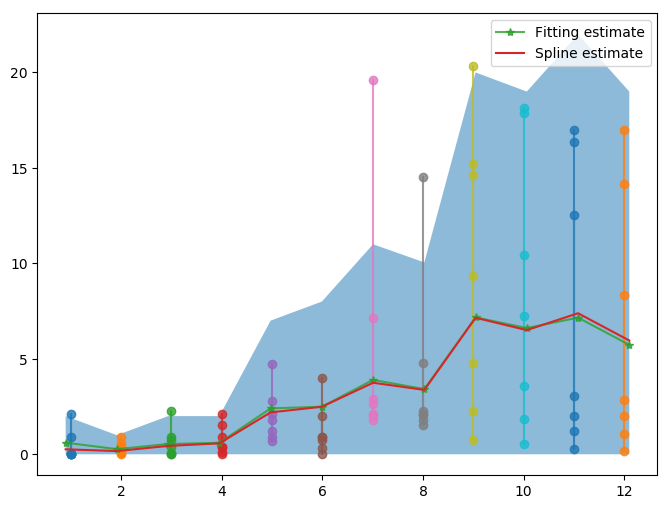

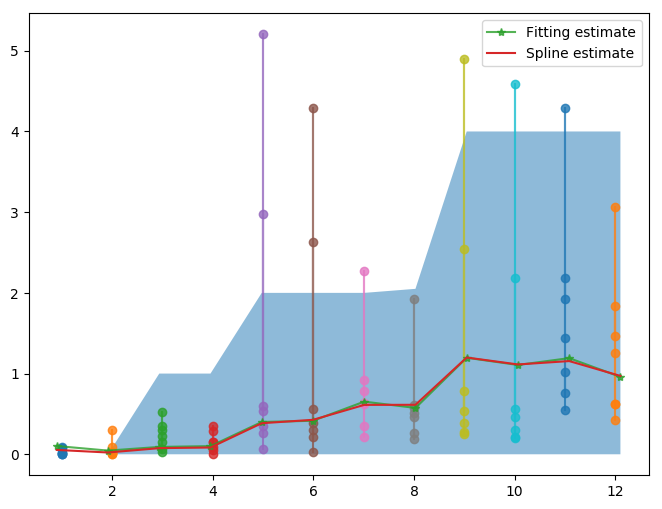

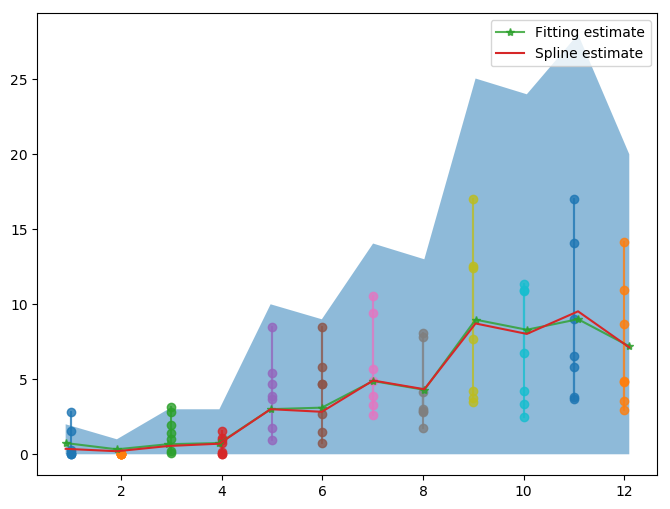

In [29]:
# 后验分析
varnames2 = ['theta']
tmp = pm.df_summary(trace_1, varnames2)
betaMAP = tmp['mean'][np.arange(12)]
betaMAPB = tmp['mean'][84:96]
betaMAPC = tmp['mean'][168:180]
# print(betaMAP)

with model_1:
    pp_trace = pm.sample_ppc(trace_1, 1000)
ip=0
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(0.9, 12.1, 12)
low, high = np.percentile(pp_trace['Observed'], [5, 95], axis=0)

xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
yp = elec_faults2[ip*7:(ip+1)*7, :]
ax.plot(xp, yp, marker='o', alpha=.8)
ax.plot(x_plot, betaMAP[:], marker='*', alpha=.8, label="Fitting estimate")
ax.fill_between(x_plot, low[:12], high[:12],  alpha=0.5)
ax.plot(x_plot, pp_trace['Observed'].mean(axis=0)[:12], label="Spline estimate")

ax.legend()
plt.show()


ip=1
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(0.9, 12.1, 12)
low, high = np.percentile(pp_trace['Observed'], [5, 95], axis=0)

xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
yp = elec_faults2[ip*7:(ip+1)*7, :]
ax.plot(xp, yp, marker='o', alpha=.8)
ax.plot(x_plot, betaMAPB[:], marker='*', alpha=.8, label="Fitting estimate")
ax.fill_between(x_plot, low[84:96], high[84:96],  alpha=0.5)
ax.plot(x_plot, pp_trace['Observed'].mean(axis=0)[84:96], label="Spline estimate")

ax.legend()
plt.show()


ip=2
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(0.9, 12.1, 12)
low, high = np.percentile(pp_trace['Observed'], [5, 95], axis=0)

xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
yp = elec_faults2[ip*7:(ip+1)*7, :]
ax.plot(xp, yp, marker='o', alpha=.8)
ax.plot(x_plot, betaMAPC[:], marker='*', alpha=.8, label="Fitting estimate")
ax.fill_between(x_plot, low[168:180], high[168:180],  alpha=0.5)
ax.plot(x_plot, pp_trace['Observed'].mean(axis=0)[168:180], label="Spline estimate")

ax.legend()
plt.show()

theta__0     0.607498
theta__1     0.268615
theta__2     0.540424
theta__3     0.599698
theta__4     2.402910
theta__5     2.492828
theta__6     3.895967
theta__7     3.415338
theta__8     7.169654
theta__9     6.611927
theta__10    7.158055
theta__11    5.731707
Name: mean, dtype: float64


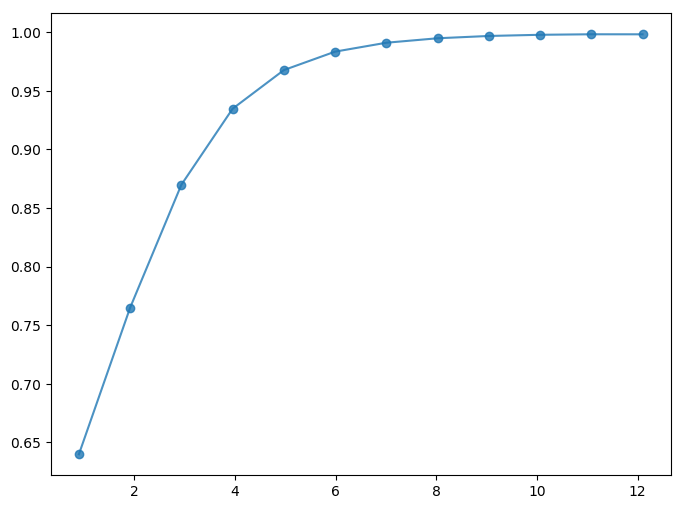

In [30]:
def Invlogit(x):
    return tt.exp(x)/(1+tt.exp(x))
varnames2 = ['psi']
tmp = pm.df_summary(trace_1, varnames2)
psiMAP = tmp['mean'][np.arange(12)]
print(betaMAP)
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(0.9, 12.1, 12)
ax.plot(x_plot, psiMAP, marker='o', alpha=.8)
plt.show()

In [9]:
# The Gelman-Rubin statistics indicate that the chains have converged
max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace_1).values())

ValueError: Gelman-Rubin diagnostic requires multiple chains of the same length.